# Библиотеки

In [ ]:
!pip install catboost sentence_transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [ ]:
import gdown
import pandas as pd
import ast
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import torch
import re
from sklearn.decomposition import PCA
import pandas as pd
import joblib
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используется устройство: {device}")

Используется устройство: cuda


In [ ]:
!nvidia-smi

Thu Sep 18 09:04:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Загрузка датасета

In [ ]:
url = 'https://drive.google.com/uc?id=1CVGDaa42dd3CsYysAlW3sl9HToRxYx7f'
name_file = 'train_contest.csv'
gdown.download(url, name_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1CVGDaa42dd3CsYysAlW3sl9HToRxYx7f
From (redirected): https://drive.google.com/uc?id=1CVGDaa42dd3CsYysAlW3sl9HToRxYx7f&confirm=t&uuid=d94667e3-ffe9-49a4-bfe0-f5d1db861783
To: /content/train_contest.csv
100%|██████████| 177M/177M [00:01<00:00, 130MB/s]


'train_contest.csv'

In [ ]:
name_file = 'train_contest.csv'
df = pd.read_csv(name_file)
df.sample(1)

,premium,name,department,has_test,response_letter_required,area,type,address,response_url,sort_point_distance,...,working_time_intervals,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,immediate_redirect_url,mean_salary
6697,False,Cервисный инженер IT-оборудования (Обслуживани...,NaN,False,False,"{'id': '304', 'name': 'Салехард', 'url': 'http...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,...,"[{'id': 'from_four_to_six_hours_in_a_day', 'na...",[],False,<p>В связи с развитием сети сервисных центров ...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Системы видеонаблюдения'}, {'name':...","[{'id': '1.270', 'name': 'Сетевые технологии',...",Ямало-Ненецкий АО,NaN,42500.0


# Очистка датасета

In [ ]:
df = df.drop(columns=['type','department','response_url', 'immediate_redirect_url','sort_point_distance','published_at','created_at','relations','url',
                      'alternate_url','contacts','working_days','insider_interview','working_time_intervals','archived'])

def safe_extract(x, n, key, default=''):
    if not isinstance(x, str):
        return default
    if not x.strip():
        return default
    try:
        lst = ast.literal_eval(x)
        if not isinstance(lst, list):
            return default
        if len(lst) <= n:
            return default
        if not isinstance(lst[n], dict):
            return default
        return lst[n].get(key, default)
    except Exception as e:
        return default

def clean_html_tags(text):
    if isinstance(text, str):
        clean = re.compile(r'<.*?>')
        return re.sub(clean, '', text)
    return text

df['snippet_requirement'] = df['snippet'].apply(lambda x: ast.literal_eval(x)['requirement'] if pd.notnull(x) else x)
df['snippet_responsibility'] = df['snippet'].apply(lambda x: ast.literal_eval(x)['responsibility'] if pd.notnull(x) else x)
df['employer'] = df['employer'].apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else x)
df['working_time_modes'] = df['working_time_modes'].apply(
    lambda x: safe_extract(x, 0, 'name') if pd.notnull(x) and x != '[]' else 'unknown'
)

df['working_time_modes'] = df['working_time_modes'].apply(
    lambda x: True if x == 'Можно начинать работать после 16:00' else False
)


df['experience'] = df['experience'].apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else x)
df['area'] = df['area'].apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else x)
df['schedule'] = df['schedule'].apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else x)
df['address'] = df['address'].apply(lambda x: ast.literal_eval(x)['city'] if pd.notnull(x) else x)

# они похожи - но могут дополнять
df['area'] = df['area'].fillna(df['address'])


df['key_skills'] = df['key_skills'].apply(lambda x: ', '.join([item['name'] for item in ast.literal_eval(x)])
              if isinstance(x, str) and x.strip()
              else ''
)


df['specialization_name_last'] = df['specializations'].apply(lambda x: safe_extract(x, 0, 'name'))
df[f'specialization_profarea_name_last'] = df['specializations'].apply(lambda x: safe_extract(x, 0, 'profarea_name'))


df['specializations'] = df['specializations'].apply(lambda x: ', '.join([item['name'] for item in ast.literal_eval(x)])
              if isinstance(x, str) and x.strip()
              else ''
)

Y = df['mean_salary']

df['description'] = df['description'].apply(clean_html_tags)

df = df.drop(columns=['address','mean_salary','snippet'])

df = df.fillna('unknown')
df = df.replace('', 'unknown')

# маленький прирост даёт
# df = df.drop(columns=['premium','has_test','response_letter_required','working_time_modes','accept_temporary'])


# по корреляционной матрице очень низкая корреляция и shap маленький вес
# df['len_specializations'] = df['specializations'].apply(
#     lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.strip() else 0
# )
# df['len_key_skills'] = df['key_skills'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.strip() else 0)
# относительно просто скиллов низкая значимость
# df['name_and_skills'] = df['name'].fillna('') + ', Ключевые навыки: ' + df['key_skills'].fillna('')


# # Извлечение 1-й (индекс 0) и 2-й (индекс 1) специализаций
# for n, suffix in [(0, 'last'), (1, 'pre_last')]:
#     df[f'specialization_name_{suffix}'] = df['specializations'].apply(lambda x: safe_extract(x, n, 'name'))
#     # df[f'specialization_profarea_id_{suffix}'] = df['specializations'].apply(lambda x: safe_extract(x, n, 'profarea_id')) # по shap бесполезны
#     df[f'specialization_profarea_name_{suffix}'] = df['specializations'].apply(lambda x: safe_extract(x, n, 'profarea_name'))

In [ ]:
df.sample(2)

,premium,name,has_test,response_letter_required,area,employer,schedule,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,snippet_requirement,snippet_responsibility,specialization_name_last,specialization_profarea_name_last
7768,False,Младший системный администратор,False,False,Красноярск,АКСИОМА,Полный день,False,False,Уже более десяти лет компания &quot;Аксиома&qu...,От 1 года до 3 лет,"Английский — A1 — Начальный, Работа в команде,...","Сетевые технологии, Системный администратор, И...",Красноярский край,Понимание принципов работы стека протоколов TC...,Мониторинг состояния оборудования компании. Об...,Сетевые технологии,"Информационные технологии, интернет, телеком"
17147,False,Системный инженер (системный администратор),False,False,Москва,"СТРОЙСОФТ, ГК",Полный день,False,False,"Обязанности: Создание, управление и поддержка...",От 3 до 6 лет,"Bash, Linux, Shell Scripting, Unix Shell Scrip...","Сетевые технологии, Системный администратор, И...",Москва,Образование высшее. Опыт работы с linux (deb-b...,"Создание, управление и поддержка инфраструктур...",Сетевые технологии,"Информационные технологии, интернет, телеком"


In [ ]:
unique_counts = df.nunique()
unique_counts

,0
premium,2
name,13521
has_test,2
response_letter_required,2
area,784
employer,12973
schedule,5
working_time_modes,2
accept_temporary,2
description,25628


<Axes: >

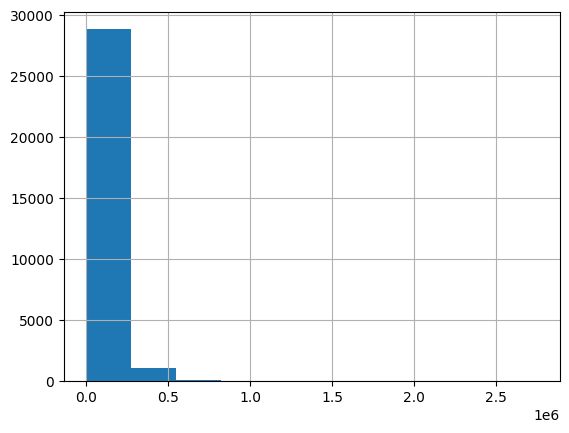

In [ ]:
Y.hist()

# text2vector - 'intfloat/multilingual-e5-small'

In [ ]:
model_T = SentenceTransformer('intfloat/multilingual-e5-small', device=device)

In [ ]:
columns_to_embed = [
    ('specializations', 'm_e5_s'),
    ('name', 'm_e5_n'),
    ('description', 'm_e5_d'),
    ('key_skills', 'm_e5_k'),
    ('employer', 'm_e5_employer'),
    ('snippet_requirement', 'm_e5_snippet_req'),
    ('snippet_responsibility', 'm_e5_snippet_respon'),
]

for col_name, prefix in columns_to_embed:
    print(f"Embedding column: {col_name}")

    texts = df[col_name].fillna('').astype(str).tolist()

    embeddings = model_T.encode(
        texts,
        show_progress_bar=True,
        normalize_embeddings=True,
        batch_size=512,
        device=device
    )

    embedding_cols = [f'{prefix}_{i}' for i in range(embeddings.shape[1])]
    embeddings_df = pd.DataFrame(embeddings, columns=embedding_cols, index=df.index)

    embeddings_df.to_csv(f'{prefix}.csv', index=False)

    df = df.drop(columns=[col_name])

Embedding column: specializations


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Embedding column: name


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Embedding column: description


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Embedding column: key_skills


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Embedding column: employer


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Embedding column: snippet_requirement


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Embedding column: snippet_responsibility


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

# Понижение размерности - PCA

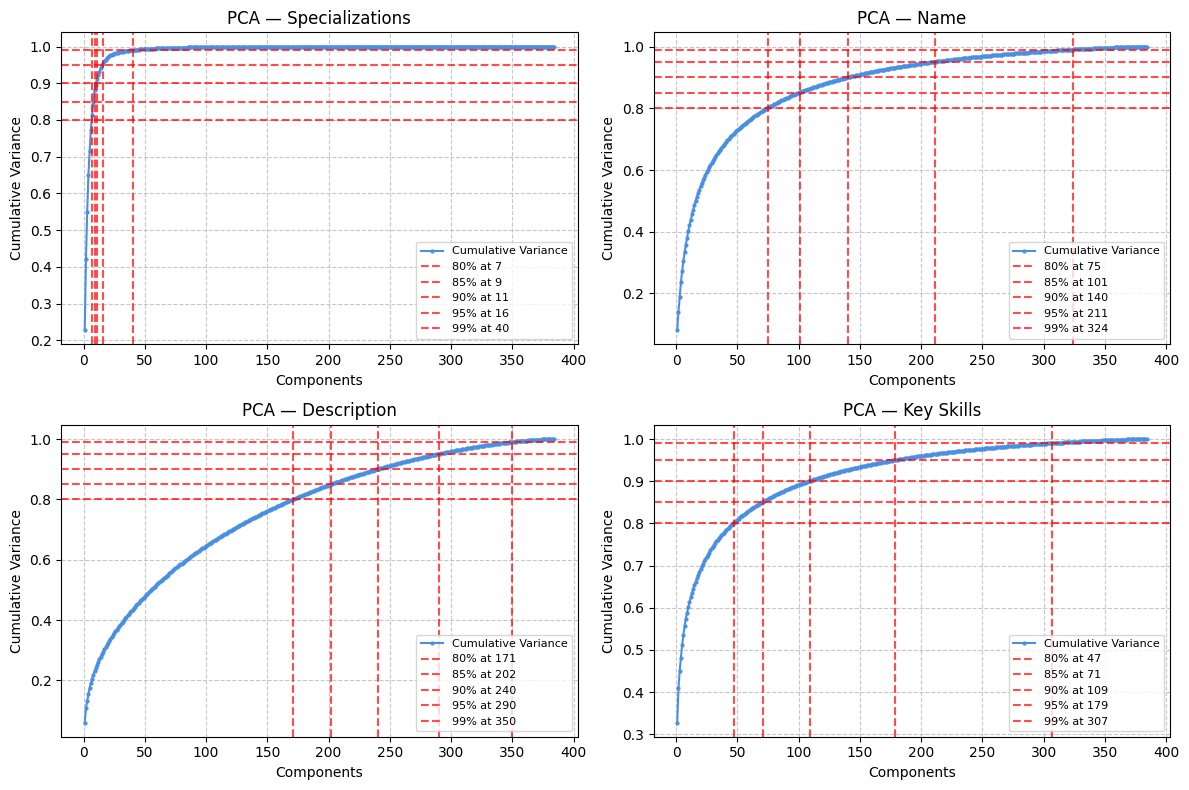

 Saved m_e5_s_pca_95.csv with 16 components (95% variance)
 Saved m_e5_n_pca_95.csv with 211 components (95% variance)
 Saved m_e5_d_pca_95.csv with 290 components (95% variance)
 Saved m_e5_k_pca_95.csv with 179 components (95% variance)


In [ ]:
# @title старый


dfs = pd.read_csv('m_e5_s.csv')
dfn = pd.read_csv('m_e5_n.csv')
dfd = pd.read_csv('m_e5_d.csv')
dfk = pd.read_csv('m_e5_k.csv')
dfemp = pd.read_csv('m_e5_employer.csv')
dfsnippet_req = pd.read_csv('m_e5_snippet_req.csv')
dfsnippet_respon = pd.read_csv('m_e5_snippet_respon.csv')

df =  pd.concat([df,dfs,dfn,dfd,dfk,dfemp,dfsnippet_req,dfsnippet_respon], axis=1)

prefixes = ['m_e5_s', 'm_e5_n', 'm_e5_d', 'm_e5_k']
titles = ['Specializations', 'Name', 'Description', 'Key Skills']
prefixes = ['m_e5_employer', 'm_e5_snippet_req', 'm_e5_snippet_respon']
titles = ['employer', 'snippet_requirement', 'snippet_responsibility']



pca_models = {}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, (prefix, title) in enumerate(zip(prefixes, titles)):
    ax = axes[idx]

    embedding_cols = [col for col in df.columns if col.startswith(prefix)]
    X_embed = df[embedding_cols].values

    pca_full = PCA()
    pca_full.fit(X_embed)
    pca_models[prefix] = pca_full
    cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

    ax.plot(range(1, len(cumsum_variance) + 1), cumsum_variance,
            marker='o', markersize=2, linestyle='-', color='#4a90e2', label='Cumulative Variance')

    thresholds = [0.8, 0.85, 0.9, 0.95, 0.99]
    for threshold in thresholds:
        comp_idx = np.argmax(cumsum_variance >= threshold) + 1
        ax.axhline(y=threshold, color='red', linestyle='--', alpha=0.7)
        ax.axvline(x=comp_idx, color='red', linestyle='--', alpha=0.7,
                   label=f'{int(threshold*100)}% at {comp_idx}')

    ax.set_title(f'PCA — {title}', fontsize=12)
    ax.set_xlabel('Components', fontsize=10)
    ax.set_ylabel('Cumulative Variance', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

for prefix in prefixes:
    embedding_cols = [col for col in df.columns if col.startswith(prefix)]
    X_embed = df[embedding_cols].values

    pca_full = pca_models[prefix]
    cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1

    X_reduced = pca_full.transform(X_embed)[:, :n_components_95]

    pca_cols = [f'{prefix}_pca_{i}' for i in range(n_components_95)]
    pca_df = pd.DataFrame(X_reduced, columns=pca_cols, index=df.index)

    output_filename = f'{prefix}_pca_95.csv'
    pca_df.to_csv(output_filename, index=False)
    print(f" Saved {output_filename} with {n_components_95} components (95% variance)")

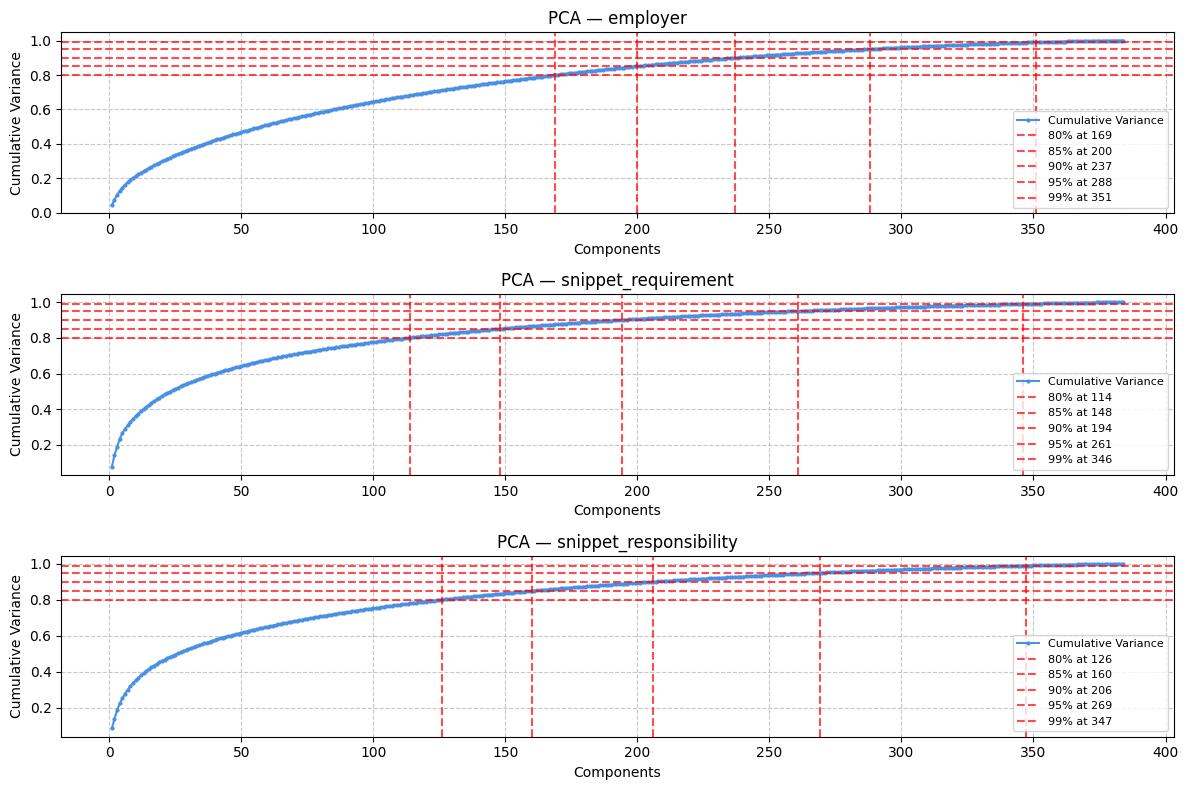

 Saved m_e5_employer_pca_95.csv with 288 components (95% variance)
 Saved m_e5_snippet_req_pca_95.csv with 261 components (95% variance)
 Saved m_e5_snippet_respon_pca_95.csv with 269 components (95% variance)


In [ ]:
# @title старый
prefixes = ['m_e5_employer', 'm_e5_snippet_req', 'm_e5_snippet_respon']
titles = ['employer', 'snippet_requirement', 'snippet_responsibility']

pca_models = {}

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
axes = axes.flatten()

for idx, (prefix, title) in enumerate(zip(prefixes, titles)):
    ax = axes[idx]

    embedding_cols = [col for col in df.columns if col.startswith(prefix)]
    X_embed = df[embedding_cols].values

    pca_full = PCA()
    pca_full.fit(X_embed)
    pca_models[prefix] = pca_full
    cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

    ax.plot(range(1, len(cumsum_variance) + 1), cumsum_variance,
            marker='o', markersize=2, linestyle='-', color='#4a90e2', label='Cumulative Variance')

    thresholds = [0.8, 0.85, 0.9, 0.95, 0.99]
    for threshold in thresholds:
        comp_idx = np.argmax(cumsum_variance >= threshold) + 1
        ax.axhline(y=threshold, color='red', linestyle='--', alpha=0.7)
        ax.axvline(x=comp_idx, color='red', linestyle='--', alpha=0.7,
                   label=f'{int(threshold*100)}% at {comp_idx}')

    ax.set_title(f'PCA — {title}', fontsize=12)
    ax.set_xlabel('Components', fontsize=10)
    ax.set_ylabel('Cumulative Variance', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

for prefix in prefixes:
    embedding_cols = [col for col in df.columns if col.startswith(prefix)]
    X_embed = df[embedding_cols].values

    pca_full = pca_models[prefix]
    cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1

    X_reduced = pca_full.transform(X_embed)[:, :n_components_95]

    pca_cols = [f'{prefix}_pca_{i}' for i in range(n_components_95)]
    pca_df = pd.DataFrame(X_reduced, columns=pca_cols, index=df.index)

    output_filename = f'{prefix}_pca_95.csv'
    pca_df.to_csv(output_filename, index=False)
    print(f" Saved {output_filename} with {n_components_95} components (95% variance)")

In [ ]:
files = [
    'm_e5_s',
    'm_e5_n',
    'm_e5_d',
    'm_e5_k',
    'm_e5_employer',
    'm_e5_snippet_req',
    'm_e5_snippet_respon'
]
for f in files:
    print(f"→ {f}")
    df_raw = pd.read_csv(f'{f}.csv')

    pca = PCA(n_components=20, random_state=42)
    X_pca = pca.fit_transform(df_raw.values)

    joblib.dump(pca, f'{f}_pca_20.joblib')

    pca_cols = [f'{f}_pca_{i}' for i in range(20)]
    df_pca = pd.DataFrame(X_pca, columns=pca_cols)
    df_pca.to_csv(f'{f}_pca_20.csv', index=False)

    print(f"Сохранены: {f}_pca_20.csv и {f}_pca_20.joblib")

→ m_e5_s
Сохранены: m_e5_s_pca_20.csv и m_e5_s_pca_20.joblib
→ m_e5_n
Сохранены: m_e5_n_pca_20.csv и m_e5_n_pca_20.joblib
→ m_e5_d
Сохранены: m_e5_d_pca_20.csv и m_e5_d_pca_20.joblib
→ m_e5_k
Сохранены: m_e5_k_pca_20.csv и m_e5_k_pca_20.joblib
→ m_e5_employer
Сохранены: m_e5_employer_pca_20.csv и m_e5_employer_pca_20.joblib
→ m_e5_snippet_req
Сохранены: m_e5_snippet_req_pca_20.csv и m_e5_snippet_req_pca_20.joblib
→ m_e5_snippet_respon
Сохранены: m_e5_snippet_respon_pca_20.csv и m_e5_snippet_respon_pca_20.joblib


# Признаки с PCA + признаки с датасета

In [ ]:
dfs = pd.read_csv('m_e5_s.csv') # 384
dfn = pd.read_csv('m_e5_n.csv') # 384
dfd = pd.read_csv('m_e5_d.csv') # 384
dfk = pd.read_csv('m_e5_k.csv') # 384

df_sndk =  pd.concat([df,dfs,dfn,dfd,dfk], axis=1) # 1546
print(df_sndk.shape)

(30072, 1546)


In [ ]:
# п
dfs_pca_95 = pd.read_csv('m_e5_s_pca_95.csv') # 16
dfn_pca_95 = pd.read_csv('m_e5_n_pca_95.csv') # 211
dfd_pca_95 = pd.read_csv('m_e5_d_pca_95.csv') # 290
dfk_pca_95 = pd.read_csv('m_e5_k_pca_95.csv') # 179

dfemp = pd.read_csv('m_e5_employer_pca_95.csv') # 288
dfsnippet_req = pd.read_csv('m_e5_snippet_req_pca_95.csv') # 261
dfrespon_pca = pd.read_csv('m_e5_snippet_respon_pca_95.csv') # 269

df_pca_95 =  pd.concat([df,dfs_pca_95,dfn_pca_95,dfd_pca_95,dfk_pca_95], axis=1) # 706
print(df_pca_95.shape)

(30072, 706)


# Итоговые признаки

In [ ]:
dfs_pca_20 = pd.read_csv('m_e5_s_pca_20.csv')          # специализации
dfn_pca_20 = pd.read_csv('m_e5_n_pca_20.csv')          # название
dfd_pca_20 = pd.read_csv('m_e5_d_pca_20.csv')          # описание
dfk_pca_20 = pd.read_csv('m_e5_k_pca_20.csv')          # ключевые навыки
dfemp_pca_20 = pd.read_csv('m_e5_employer_pca_20.csv') # работодатель
dfreq_pca_20 = pd.read_csv('m_e5_snippet_req_pca_20.csv')     # требования
dfres_pca_20 = pd.read_csv('m_e5_snippet_respon_pca_20.csv')  # обязанности

df_20 =  pd.concat([df,dfs_pca_20,dfn_pca_20,dfd_pca_20,dfk_pca_20,dfemp_pca_20,dfreq_pca_20,dfres_pca_20], axis=1)
print(df_20.shape)

(30072, 158)


In [ ]:
X = df_20
print(df_20.shape)

(30072, 108)


In [ ]:
# если нету не
X = X.drop(columns=['description','name','key_skills','specializations','employer','snippet_requirement','snippet_responsibility'])

In [ ]:
X.sample(2)

,area,schedule,experience,region,specialization_name_last,specialization_profarea_name_last,m_e5_s_pca_0,m_e5_s_pca_1,m_e5_s_pca_2,m_e5_s_pca_3,...,m_e5_snippet_respon_pca_0,m_e5_snippet_respon_pca_1,m_e5_snippet_respon_pca_2,m_e5_snippet_respon_pca_3,m_e5_snippet_respon_pca_4,m_e5_snippet_respon_pca_5,m_e5_snippet_respon_pca_6,m_e5_snippet_respon_pca_7,m_e5_snippet_respon_pca_8,m_e5_snippet_respon_pca_9
25985,Краснознаменск (Московская область),Полный день,От 1 года до 3 лет,Московская область,Тренерский состав,"Спортивные клубы, фитнес, салоны красоты",-0.056475,0.159820,0.173139,-0.120009,...,0.058605,0.033613,0.04713,0.014562,-0.043677,-0.067761,0.095051,-0.035802,-0.116271,-0.084766
9947,Пермь,Полный день,От 3 до 6 лет,Пермский край,"Информационные технологии, Интернет, Мультимедиа",Высший менеджмент,0.042774,0.001606,0.059742,-0.002576,...,0.054478,-0.052228,0.00494,-0.006913,-0.023594,-0.136069,0.002501,-0.091235,-0.079895,-0.004708


array([[<Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'log(Y)'}>]], dtype=object)

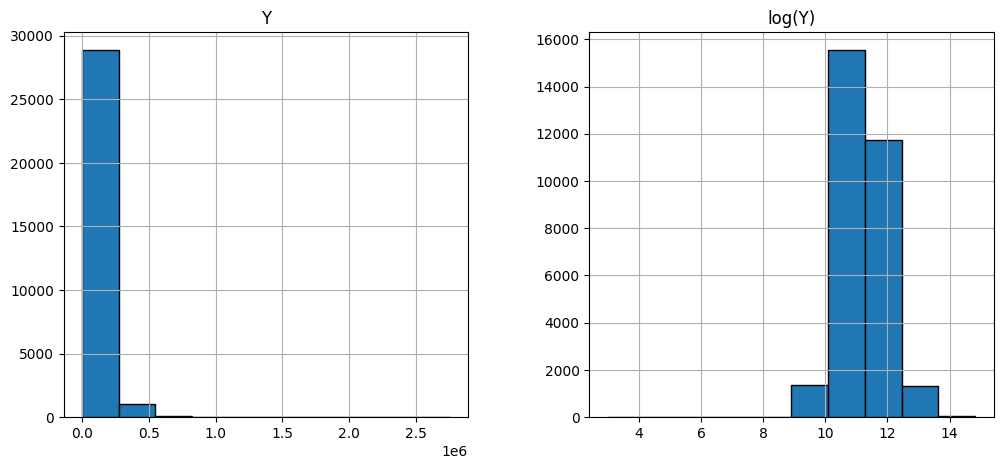

In [ ]:
pd.DataFrame({'Y': Y, 'log(Y)': np.log(Y)}).hist(figsize=(12, 5), edgecolor='black')

# Обучение catboost + categorical_features

In [ ]:
Y_original = Y.copy()
_Y = np.log(Y)

categorical_features = ['area', 'schedule', 'experience','region','specialization_name_last','specialization_profarea_name_last']

X_train, X_test, y_train, y_test = train_test_split(X, _Y, test_size=0.2, random_state=42)

y_train_original = np.exp(y_train)
y_test_original = np.exp(y_test)

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

model = CatBoostRegressor(iterations=1000, loss_function='MAE', verbose=False)
model.fit(train_pool, eval_set=test_pool)


y_train_pred_log = model.predict(X_train)
y_test_pred_log = model.predict(X_test)
y_train_pred = np.exp(y_train_pred_log)
y_test_pred = np.exp(y_test_pred_log)

mae_train = mean_absolute_error(y_train_original, y_train_pred)
mae_test = mean_absolute_error(y_test_original, y_test_pred)

print(f'MAE на обучающей выборке (в исходных единицах): {mae_train:.2f}')
print(f'MAE на тестовой выборке (в исходных единицах): {mae_test:.2f}')

MAE на обучающей выборке (в исходных единицах): 26857.50
MAE на тестовой выборке (в исходных единицах): 28966.20


# Ошибка на val + train

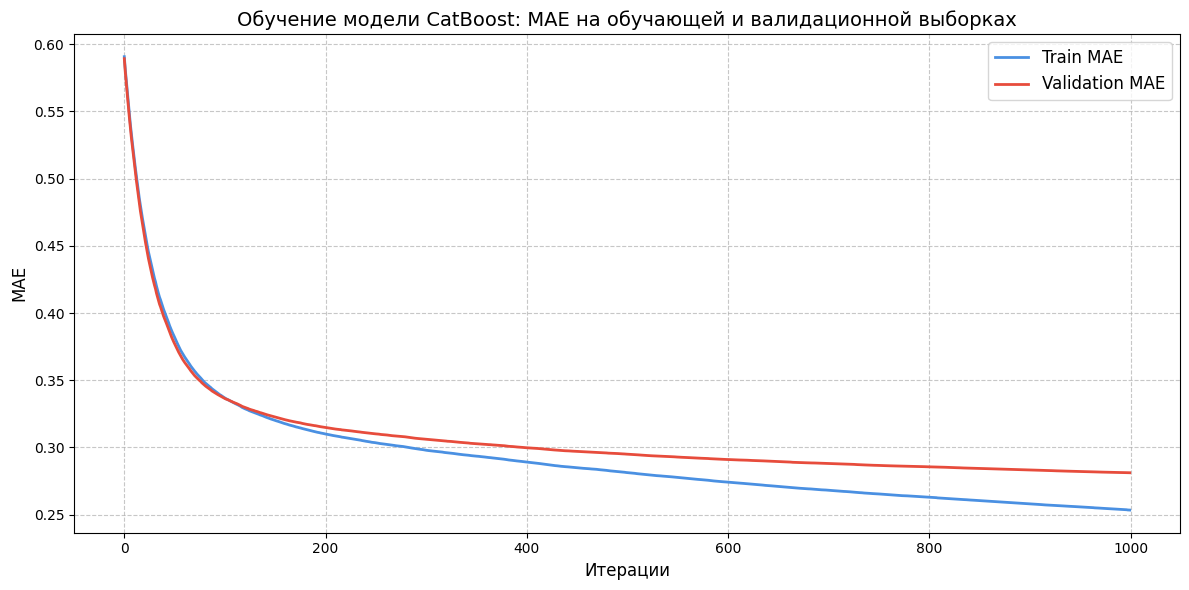

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(model.evals_result_['learn']['MAE'], label='Train MAE', color='#4a90e2', linewidth=2)
plt.plot(model.evals_result_['validation']['MAE'], label='Validation MAE', color='#e74c3c', linewidth=2)

plt.xlabel('Итерации', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('Обучение модели CatBoost: MAE на обучающей и валидационной выборках', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Важность признаков

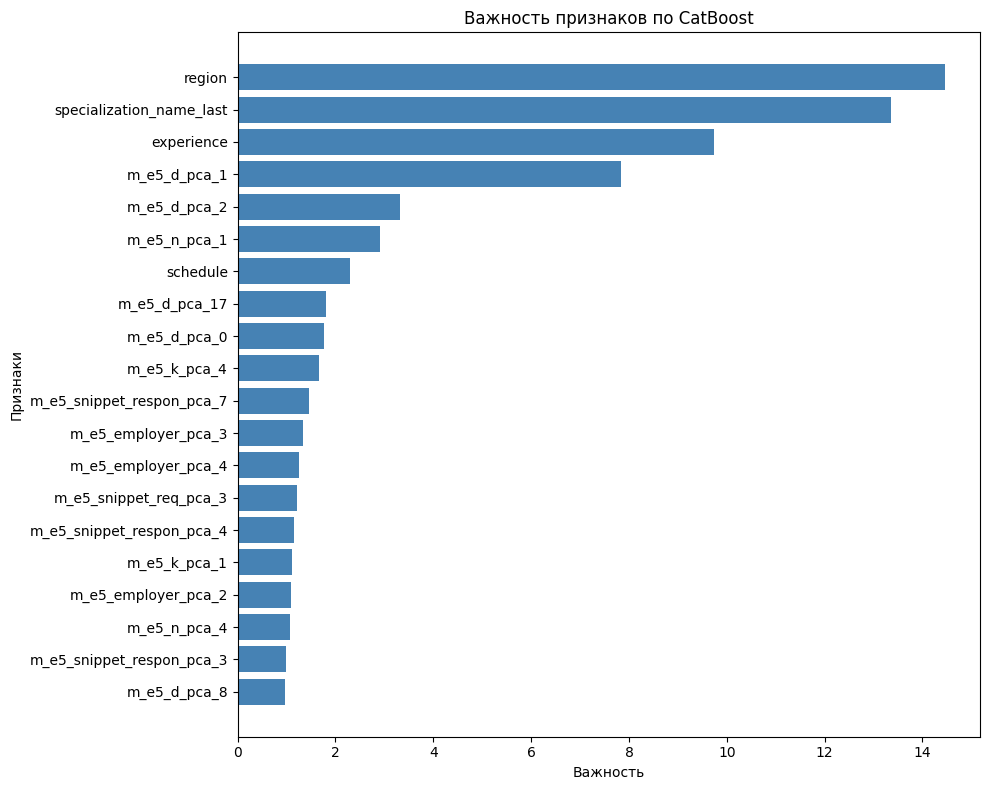

In [ ]:
feature_importances = model.get_feature_importance(train_pool)
feature_names = X.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

importance_df = importance_df.iloc[:20]


plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков по CatBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Финальная модель

In [ ]:
_Y = np.log(Y)


categorical_features = [
    'area', 'schedule', 'experience', 'region',
    'specialization_name_last', 'specialization_profarea_name_last'
]


full_pool = Pool(X, _Y, cat_features=categorical_features)


model_final = CatBoostRegressor(
    iterations=1000,
    loss_function='MAE',
    verbose=False,
    random_seed=42
)

model_final.fit(full_pool)


model_final.save_model('catboost_salary_model_final.cbm')
print("Финальная модель обучена и сохранена: catboost_salary_model_final.cbm")

# PROD

In [ ]:
# url = 'https://drive.google.com/file/d/1OQvgn1fodqk18A5zr_vYShbOmHyThpsE/view?usp=drive_link'
# name_file = 'for_prediction.csv'
# gdown.download(url, name_file, quiet=False)

In [ ]:
df = pd.read_csv('for_prediction.csv')
df.sample(1)

,Id,premium,name,department,has_test,response_letter_required,area,type,address,response_url,...,working_days,working_time_intervals,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,immediate_redirect_url
4575,4575,False,Ведущий инженер-программист (1С),NaN,False,False,"{'id': '104', 'name': 'Челябинск', 'url': 'htt...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Челябинск', 'street': 'улица Воровск...",NaN,...,[],[],[],False,<strong>Обязанности:</strong> <ul> <li>Разрабо...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': '1С программирование'}, {'name': 'ОО...","[{'id': '1.221', 'name': 'Программирование, Ра...",Челябинская область,NaN


In [ ]:
df = df.drop(columns=['Id','department','response_url', 'immediate_redirect_url','sort_point_distance','published_at','created_at','relations','url',
                      'alternate_url','contacts','working_days','insider_interview','working_time_intervals','archived','type'])

def safe_extract(x, n, key, default=''):
    if not isinstance(x, str):
        return default
    if not x.strip():
        return default
    try:
        lst = ast.literal_eval(x)
        if not isinstance(lst, list):
            return default
        if len(lst) <= n:
            return default
        if not isinstance(lst[n], dict):
            return default
        return lst[n].get(key, default)
    except Exception as e:
        return default

def clean_html_tags(text):
    if isinstance(text, str):
        clean = re.compile(r'<.*?>')
        return re.sub(clean, '', text)
    return text

df['snippet_requirement'] = df['snippet'].apply(lambda x: ast.literal_eval(x)['requirement'] if pd.notnull(x) else x)
df['snippet_responsibility'] = df['snippet'].apply(lambda x: ast.literal_eval(x)['responsibility'] if pd.notnull(x) else x)
df['employer'] = df['employer'].apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else x)
df['working_time_modes'] = df['working_time_modes'].apply(
    lambda x: safe_extract(x, 0, 'name') if pd.notnull(x) and x != '[]' else 'unknown'
)

df['working_time_modes'] = df['working_time_modes'].apply(
    lambda x: True if x == 'Можно начинать работать после 16:00' else False
)



df['experience'] = df['experience'].apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else x)
df['area'] = df['area'].apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else x)
df['schedule'] = df['schedule'].apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else x)
df['address'] = df['address'].apply(lambda x: ast.literal_eval(x)['city'] if pd.notnull(x) else x)

# они похожи - но могут дополнять
df['area'] = df['area'].fillna(df['address'])


df['key_skills'] = df['key_skills'].apply(lambda x: ', '.join([item['name'] for item in ast.literal_eval(x)])
              if isinstance(x, str) and x.strip()
              else ''
)


df['specialization_name_last'] = df['specializations'].apply(lambda x: safe_extract(x, 0, 'name'))
df[f'specialization_profarea_name_last'] = df['specializations'].apply(lambda x: safe_extract(x, 0, 'profarea_name'))


df['specializations'] = df['specializations'].apply(lambda x: ', '.join([item['name'] for item in ast.literal_eval(x)])
              if isinstance(x, str) and x.strip()
              else ''
)

# Y = df['mean_salary']

df['description'] = df['description'].apply(clean_html_tags)

df = df.drop(columns=['address','snippet'])

df = df.fillna('unknown')
df = df.replace('', 'unknown')


df = df.drop(columns=['premium','has_test','response_letter_required','working_time_modes','accept_temporary'])

In [ ]:
df.sample(1)

,premium,name,has_test,response_letter_required,area,type,employer,schedule,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,snippet_requirement,snippet_responsibility,specialization_name_last,specialization_profarea_name_last
4735,False,Менеджер IT-отдела,False,False,Краснодар,"{'id': 'open', 'name': 'Открытая'}",Торговая сеть ТАБРИС,Полный день,False,False,Основные обязанности: Ведение и курирование р...,От 1 года до 3 лет,unknown,"Начальный уровень, Мало опыта, Системный админ...",Краснодарский край,Высшее техническое или экономическое образован...,Ведение и курирование работы с подрядчиками и ...,"Начальный уровень, Мало опыта","Информационные технологии, интернет, телеком"


In [ ]:
model_T = SentenceTransformer('intfloat/multilingual-e5-small', device=device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [ ]:
columns_to_embed = [
    ('specializations', 'm_e5_s'),
    ('name', 'm_e5_n'),
    ('description', 'm_e5_d'),
    ('key_skills', 'm_e5_k'),
    ('employer', 'm_e5_employer'),
    ('snippet_requirement', 'm_e5_snippet_req'),
    ('snippet_responsibility', 'm_e5_snippet_respon'),
]

for col_name, prefix in columns_to_embed:
    print(f"Embedding column: {col_name}")

    texts = df[col_name].fillna('').astype(str).tolist()

    embeddings = model_T.encode(
        texts,
        show_progress_bar=True,
        normalize_embeddings=True,
        batch_size=512,
        device=device
    )

    embedding_cols = [f'{prefix}_{i}' for i in range(embeddings.shape[1])]
    embeddings_df = pd.DataFrame(embeddings, columns=embedding_cols, index=df.index)

    embeddings_df.to_csv(f'{prefix}_test.csv', index=False)

    df = df.drop(columns=[col_name])

Embedding column: specializations


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Embedding column: name


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Embedding column: description


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Embedding column: key_skills


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Embedding column: employer


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Embedding column: snippet_requirement


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Embedding column: snippet_responsibility


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
files = [
    'm_e5_s',
    'm_e5_n',
    'm_e5_d',
    'm_e5_k',
    'm_e5_employer',
    'm_e5_snippet_req',
    'm_e5_snippet_respon'
]

for f in files:
    print(f"→ Обработка теста для: {f}")

    pca_model = joblib.load(f'{f}_pca_20.joblib')

    df_test_raw = pd.read_csv(f'{f}_test.csv')

    X_test_pca = pca_model.transform(df_test_raw.values)

    pca_cols = [f'{f}_pca_{i}' for i in range(20)]
    df_test_pca = pd.DataFrame(X_test_pca, columns=pca_cols)


    output_filename = f'{f}_test_pca_20.csv'
    df_test_pca.to_csv(output_filename, index=False)

    print(f" Сохранено: {output_filename} | Размерность: {df_test_pca.shape}")

In [ ]:
dfs_test_pca_20 = pd.read_csv('m_e5_s_test_pca_20.csv')          # специализации
dfn_test_pca_20 = pd.read_csv('m_e5_n_test_pca_20.csv')          # название
dfd_test_pca_20 = pd.read_csv('m_e5_d_test_pca_20.csv')          # описание
dfk_test_pca_20 = pd.read_csv('m_e5_k_test_pca_20.csv')          # ключевые навыки
dfemp_test_pca_20 = pd.read_csv('m_e5_employer_test_pca_20.csv') # работодатель
dfreq_test_pca_20 = pd.read_csv('m_e5_snippet_req_test_pca_20.csv')     # требования
dfres_test_pca_20 = pd.read_csv('m_e5_snippet_respon_test_pca_20.csv')  # обязанности

In [ ]:
df_20 =  pd.concat([df,dfs_test_pca_20,dfn_test_pca_20,dfd_test_pca_20,dfk_test_pca_20,dfemp_test_pca_20,dfreq_test_pca_20,dfres_test_pca_20], axis=1)
print(df_20.shape)

(7518, 151)


In [ ]:
X = df_20

In [ ]:
unique_counts = df.nunique()

unique_counts

,0
premium,2
has_test,2
response_letter_required,2
area,455
schedule,5
working_time_modes,2
accept_temporary,2
experience,4
region,82
specialization_name_last,81


# Cкоринг

In [ ]:
categorical_features = [
    'area', 'schedule', 'experience', 'region',
    'specialization_name_last', 'specialization_profarea_name_last'
]
X[categorical_features] = X[categorical_features].fillna('unknown')


model = CatBoostRegressor()
model.load_model('catboost_salary_model_final.cbm')
test_pool = Pool(X, cat_features=categorical_features)
predictions_log = model.predict(test_pool)
predictions = np.exp(predictions_log)


df = pd.DataFrame({
    'Id': range(len(predictions)),
    'Predicted': predictions
})
df.to_csv('predictions.csv', index=False)

In [ ]:
df

,Id,Predicted
0,0,52231.757950
1,1,57632.687690
2,2,35351.599462
3,3,175609.214902
4,4,66587.024543
...,...,...
7513,7513,39197.857937
7514,7514,79782.076986
7515,7515,58207.314270
7516,7516,94015.577369
